Set up logging.

In [1]:
import logging

logging.basicConfig(level=logging.INFO)

# Visualizing papers citing “Gensim–python framework for VSM”
## Preprocessing

Set up text preprocessing routines.

In [2]:
import os

from gensim.parsing.preprocessing import (
    preprocess_string,
    remove_stopwords,
    strip_multiple_whitespaces,
    strip_numeric,
    strip_punctuation,
    strip_short,
    strip_tags,
)    
import nltk


custom_filters = [
    lambda x: x.lower(),
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    remove_stopwords,
    strip_short,
]

nltk.download('words')
english_words = set(word.lower() for word in nltk.corpus.words.words())


def filter_sentences_from_text(text_lines, min_line_len=20, min_sen_len=15):
    fulltext = " ".join([line for line in list(text_lines) if len([l for l in line.split(" ") 
                                                                   if len(l) > 0]) > min_line_len])
    sens = filter(lambda sen: len(sen) >= min_sen_len, fulltext.split("."))
    return ". ".join(sens)

def get_texts_from_dir(texts_dir, filter_sen=False):
    txt_files = os.listdir(texts_dir)
    txt_files = [os.path.join(texts_dir, txt) for txt in txt_files]
    texts = dict()
    for txt_f in list(filter(lambda path: path.endswith(".txt"), txt_files)):
        try:
            if filter_sen:
                # custom filtering based on sentences length:
                text = filter_sentences_from_text(open(txt_f, "r").readlines())
            else:
                # no filtering:
                text = open(txt_f, "r").read()
            text = open(txt_f, "r").read()
            texts[os.path.basename(txt_f)] = [
                word for word in preprocess_string(text, custom_filters)
                if word in english_words
            ]
        except UnicodeDecodeError:
            print("Utf-8 decode error on %s" % txt_f)
            continue
    return texts

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


[nltk_data] Downloading package words to /home/witiko/nltk_data...
[nltk_data]   Package words is already up-to-date!


Preprocess and load the datasets.

In [3]:
htmls_preproc = get_texts_from_dir('data/fulltexts_html', filter_sen=True)
pdfs_preproc = get_texts_from_dir('data/fulltexts_pdf', filter_sen=False)
merged_texts_preproc = {**htmls_preproc, **pdfs_preproc}

text_links = [name for name, text in merged_texts_preproc.items() if len(text) > 0]
texts = [merged_texts_preproc[name] for name in text_links]

Construct a dictionary and a corpus.

In [4]:
from gensim.corpora.dictionary import Dictionary


dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(24706 unique tokens: ['overlong', 'konstantin', 'navel', 'dimerization', 'presenter']...) from 1257 documents (total 2909278 corpus positions)


## Topic modeling

Compute a rank-2 and rank-30 approximations of the tf-idf term-document matrix using the Latent Semantic Analysis (LSA), and the Latent Discriminant Allocation (LDA). We will use the LSA rank-2 approximation to plot the documents in $\mathbb R^2$ and the LDA rank-30 approximations for topic modeling.

In [5]:
from gensim.models import LdaModel, LsiModel, TfidfModel


tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

lda_model_2d = LdaModel(tfidf_corpus, id2word=dictionary, num_topics=2)
lda_model_30d = LdaModel(tfidf_corpus, id2word=dictionary, num_topics=30)

lsa_model_2d = LsiModel(tfidf_corpus, id2word=dictionary, num_topics=2)

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:calculating IDF weights for 1257 documents and 24705 features (734635 matrix non-zeros)
INFO:gensim.models.ldamodel:using symmetric alpha at 0.5
INFO:gensim.models.ldamodel:using symmetric eta at 0.5
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 1257 documents, updating model once every 1257 documents, evaluating perplexity every 1257 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-11.646 per-word bound, 3205.4 perplexity estimate based on a held-out corpus of 1257 documents with 13381 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #1257/1257
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.001*"scholar" + 0.001*"word" + 0.001*"model" +

## Visualization
### Using Latent Discriminant Allocation
Transform the sparse corpus vectors to dense 2D vectors using LDA, L2-normalize them, and plot them.

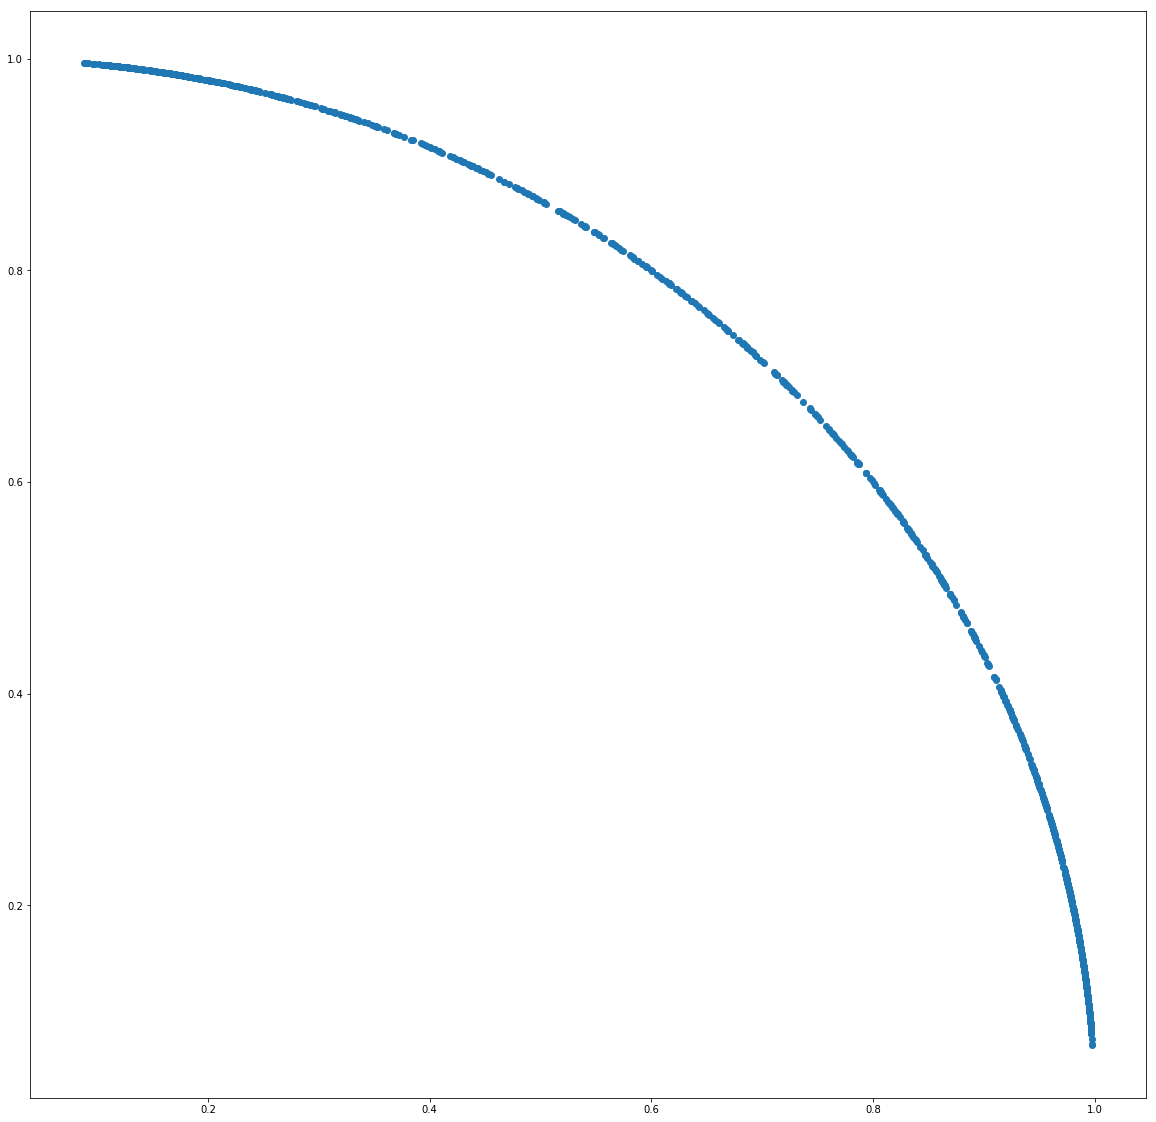

In [65]:
import matplotlib.pyplot as plt
import numpy as np

document_topics = []
for coordinates in lda_model_2d[tfidf_corpus]:
    coordinate_dict = dict(coordinates)
    document_topics.append((
        coordinate_dict[0] if 0 in coordinate_dict else 0.0,
        coordinate_dict[1] if 1 in coordinate_dict else 0.0
    ))
document_topics = np.asfarray(document_topics)
document_topics /= np.linalg.norm(document_topics, axis=1)[:, np.newaxis]

ax = plt.figure(figsize=(20, 20))
plt.scatter(document_topics[:, 0], document_topics[:, 1])

Hand-pick a cluster from the above plot.

In [66]:
x = document_topics[:, 0]

print('\n'.join([
    '{}\n\tMain topic: {}\n\tText:    {}\n'.format(
        text_links[index],
        lda_model_30d.print_topic(sorted(
            lda_model_30d.get_document_topics(tfidf_corpus[index]),
            key=lambda x: x[1]
        )[-1][0]),
        '{} …'.format(' '.join(texts[index][:50]))
    )
    for index in ((x < 0.75) & (x > 0.71)).nonzero()[0]
]))

term.00014.txt
	Main topic: 0.003*"scholar" + 0.002*"enter" + 0.001*"sign" + 0.001*"table" + 0.001*"title" + 0.001*"purchase" + 0.001*"sentiment" + 0.001*"password" + 0.001*"privacy" + 0.001*"policy"
	Text:    use track usage understand login contact support advanced search share login institutional login register password login need login help registered share add create publication alert export recommend library form title terminology international journal theoretical applied specialized communication terminology international journal theoretical applied specialized communication recommend title library home terminology international …

Heiberger and Riebling - 2016 - Installing computational social science Facing th.txt
	Main topic: 0.002*"scholar" + 0.001*"sentiment" + 0.001*"model" + 0.001*"word" + 0.001*"summarization" + 0.001*"die" + 0.001*"social" + 0.001*"sentence" + 0.001*"document" + 0.001*"query"
	Text:    commons non commercial article distributed creative commons attribut

### Using Latent Semantic Analysis
Transform the sparse corpus vectors to dense 2D vectors using LSA, L2-normalize them, and plot them.

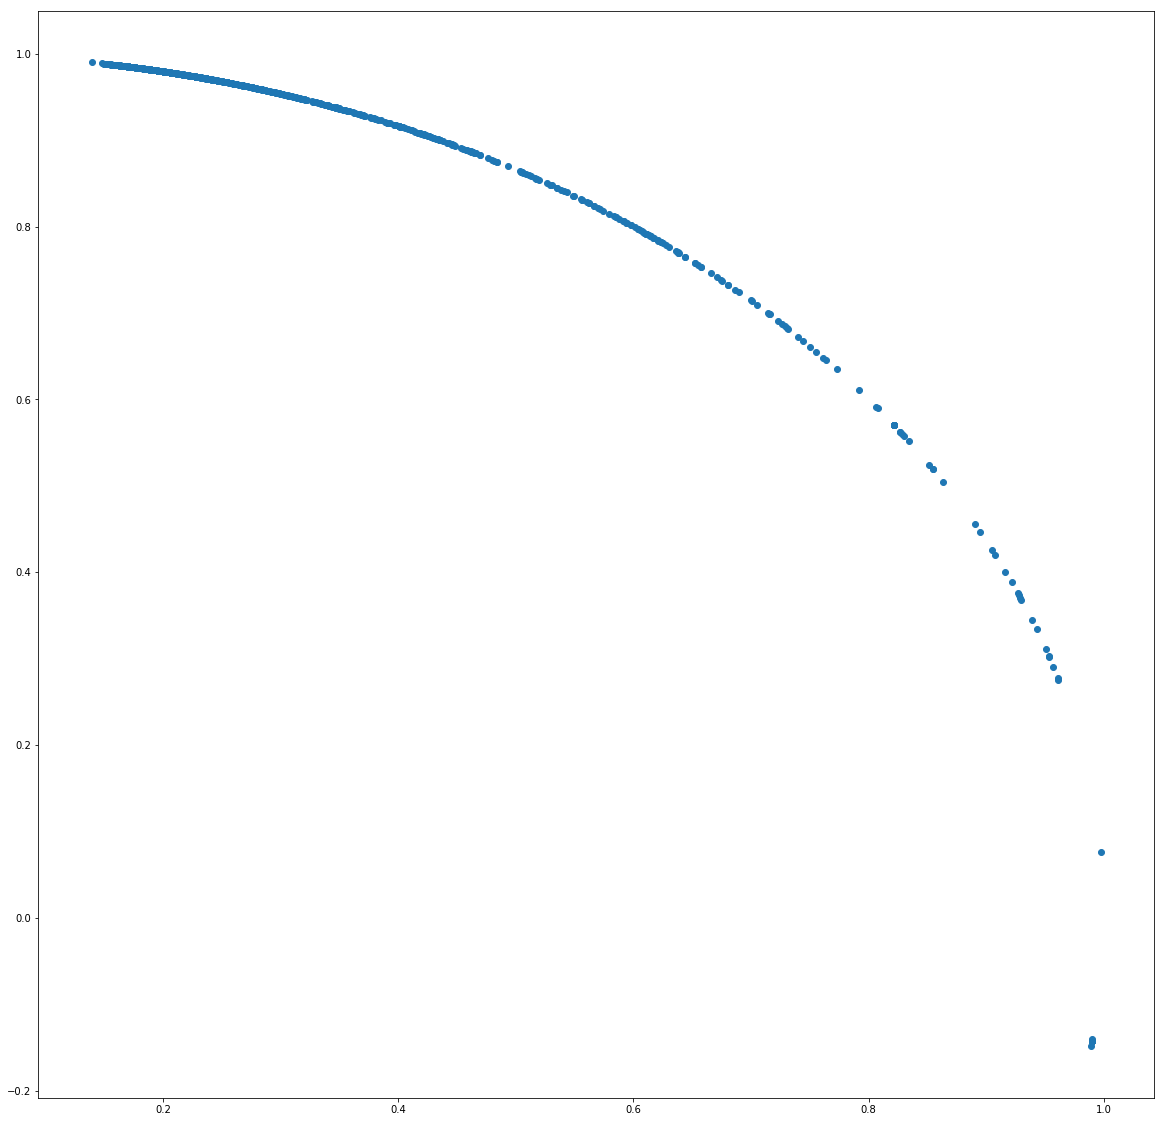

In [36]:
import matplotlib.pyplot as plt
import numpy as np


document_topics = np.asfarray(lsa_model_2d[tfidf_corpus])[:, :, 1]
document_topics /= np.linalg.norm(document_topics, axis=1)[:, np.newaxis]

ax = plt.figure(figsize=(20, 20))
plt.scatter(document_topics[:, 0], document_topics[:, 1])

Hand-pick a cluster from the above plot.

In [64]:
y = document_topics[:, 1]

print('\n'.join([
    '{}\n\tMain topic: {}\n\tText:    {}\n'.format(
        text_links[index],
        lda_model_30d.print_topic(sorted(
            lda_model_30d.get_document_topics(tfidf_corpus[index]),
            key=lambda x: x[1]
        )[-1][0]),
        '{} …'.format(' '.join(texts[index][:50]))
    )
    for index in ((y < 0.6) & (y > 0.5)).nonzero()[0]
]))

2605516.txt
	Main topic:  0.002*"scholar" + 0.001*"article" + 0.001*"sign" + 0.001*"enter" + 0.001*"word" + 0.001*"parser" + 0.001*"title" + 0.001*"purchase" + 0.001*"document" + 0.001*"gang"
	Text:        use enhance experience use agreeing use change time skip main content search account menu menu sign register search filter digital scholarship mobile search term sign register advance submit author submission site order open access purchase digital scholarship european association digital alliance digital editorial board advertising corporate career network self policy …

art00010.txt
	Main topic:  0.002*"gene" + 0.001*"recommendation" + 0.001*"clustering" + 0.001*"similarity" + 0.001*"expression" + 0.001*"neighborhood" + 0.001*"article" + 0.001*"ariadne" + 0.001*"cluster" + 0.001*"cigarette"
	Text:        skip main content toggle navigation contact help cart follow browse search search article title abstract article title article text article publication title author free accessible